# Fig. 1 The MCO Warmth Gap

In [1]:
%load_ext autoreload
%autoreload 2

import os
import x4c
import pandas as pd
import numpy as np
print(x4c.__version__)
os.chdir('/glade/work/fengzhu/Projects/paper-MCO_iCESM/notebooks')
!hostname
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
from scipy.stats import gaussian_kde

2025.6.14
crhtc76


## Load data

In [ ]:
df_eq_gmst = pd.read_csv('../data/df_eq_gmst.csv', index_col=0)
df_proxy_GMST = pd.read_csv('../data/df_proxy_GMST.csv', index_col=0)
df_proxy_d18Ob = pd.read_csv('../data/df_proxy_d18Ob.csv', index_col=0)

In [3]:
co2base = 284.7

exp = {
    'iCESM1.3': {
        'CO2': np.array([1.5, 3]),
        'dGMST': np.array([
            df_eq_gmst.loc['1.5x', 'dGMST'],
            df_eq_gmst.loc['3x', 'dGMST'],
        ])
    },
}

model_list = df_eq_gmst.index[4:]
for name in model_list:
    exp_name = ' '.join(name.split('ppm')[0].split()[:-1])
    co2ppm = float(name.split('ppm')[0].split()[-1]) / co2base

    gmst_degC = df_eq_gmst.loc[name, 'dGMST']
    if exp_name not in exp:
        exp[exp_name] = {}
        exp[exp_name]['CO2'] = [co2ppm]
        exp[exp_name]['dGMST'] = [gmst_degC]
    else:
        exp[exp_name]['CO2'].append(co2ppm)
        exp[exp_name]['dGMST'].append(gmst_degC)

exp

{'iCESM1.3': {'CO2': array([1.5, 3. ]),
  'dGMST': array([5.05721862, 9.06537037])},
 'COSMOS Late Miocene': {'CO2': [1.5806111696522656],
  'dGMST': [np.float64(6.847229957580566)]},
 'COSMOS Late Miocene ICEQ': {'CO2': [0.9764664559185108, 1.5806111696522656],
  'dGMST': [np.float64(2.338287830352783), np.float64(6.156517028808594)]},
 'HadCM3L Late Miocene': {'CO2': [0.9834913944502987, 1.4049877063575695],
  'dGMST': [np.float64(0.3331387937068939), np.float64(2.876962661743164)]},
 'HadCM3L Tortonian': {'CO2': [1.4049877063575695],
  'dGMST': [np.float64(2.412762403488159)]},
 'HadCM3L Messinian': {'CO2': [1.4049877063575695],
  'dGMST': [np.float64(2.4504244327545166)]},
 'NorESM-L 10Ma': {'CO2': [1.2293642430628733, 1.9669827889005973],
  'dGMST': [np.float64(1.7859212160110474), np.float64(4.743577480316162)]},
 'CCSM-NH3': {'CO2': [1.246926589392343, 1.9669827889005973],
  'dGMST': [np.float64(2.439183235168457), np.float64(4.000351428985596)]},
 'CCSM3 T42 MMCO': {'CO2': [1.4

## Visualization

In [ ]:
exp_names = [
    'iCESM1.3',
    'COSMOS Mid Miocene',
    'HadCM3L Mid Miocene 55SLE',
    'HadCM3L Mid Miocene NoICE',
]
gmst_dict = {k: exp[k] for k in exp_names}
lb_dict = {k: k for k in list(gmst_dict)}
lb_dict.update({
    'iCESM1.3': 'iCESM1.3',
    'A22': 'A22',
    'CCSM3 T42 MMCO': 'CCSM3 T42',
    'COSMOS Mid Miocene': 'COSMOS',
    'HadCM3L Mid Miocene 55SLE': 'HadCM3L 55SLE',
    'HadCM3L Mid Miocene NoICE': 'HadCM3L NoICE',
})

clr_dict = {
    'iCESM1.3': 'tab:blue',
    'A22': 'tab:orange',
    'CCSM3 T42 MMCO': 'tab:green',
    'COSMOS Mid Miocene': 'tab:brown',
    'HadCM3L Mid Miocene 55SLE': 'tab:purple',
    'HadCM3L Mid Miocene NoICE': 'tab:pink',
}

In [5]:
for name in ['COSMOS Mid Miocene', 'HadCM3L Mid Miocene 55SLE', 'HadCM3L Mid Miocene NoICE']:
    exp[name]['CO2'] = exp[name]['CO2'][1:]
    exp[name]['dGMST'] = exp[name]['dGMST'][1:]

In [6]:
df_CO2pdf = pd.read_csv('../data/df_CO2pdf.csv')
df_CO2pdf

,CO2,density,dBWT,dGMST,dGMSST
0,1.500000,1.308080e-03,3.331926,5.057219,4.176863
1,1.502085,1.374390e-03,3.339442,5.065251,4.183487
2,1.504173,1.443519e-03,3.346957,5.073283,4.190111
3,1.506264,1.515569e-03,3.354473,5.081316,4.196736
4,1.508358,1.590644e-03,3.361989,5.089348,4.203360
...,...,...,...,...,...
994,5.966755,7.593241e-10,10.802510,13.041393,10.761265
995,5.975049,7.039894e-10,10.810026,13.049425,10.767889
996,5.983354,6.525733e-10,10.817542,13.057457,10.774513
997,5.991671,6.048048e-10,10.825057,13.065490,10.781137


In [ ]:
from matplotlib.collections import LineCollection

def colored_line(x, y, c, ax, **lc_kwargs):
    """
    Plot a line with a color specified along the line by a third value.

    It does this by creating a collection of line segments. Each line segment is
    made up of two straight lines each connecting the current (x, y) point to the
    midpoints of the lines connecting the current point with its two neighbors.
    This creates a smooth line with no gaps between the line segments.

    Parameters
    ----------
    x, y : array-like
        The horizontal and vertical coordinates of the data points.
    c : array-like
        The color values, which should be the same size as x and y.
    ax : Axes
        Axis object on which to plot the colored line.
    **lc_kwargs
        Any additional arguments to pass to matplotlib.collections.LineCollection
        constructor. This should not include the array keyword argument because
        that is set to the color argument. If provided, it will be overridden.

    Returns
    -------
    matplotlib.collections.LineCollection
        The generated line collection representing the colored line.
    """
    if "array" in lc_kwargs:
        warnings.warn('The provided "array" keyword argument will be overridden')

    # Default the capstyle to butt so that the line segments smoothly line up
    default_kwargs = {"capstyle": "butt"}
    default_kwargs.update(lc_kwargs)

    # Compute the midpoints of the line segments. Include the first and last points
    # twice so we don't need any special syntax later to handle them.
    x = np.asarray(x)
    y = np.asarray(y)
    x_midpts = np.hstack((x[0], 0.5 * (x[1:] + x[:-1]), x[-1]))
    y_midpts = np.hstack((y[0], 0.5 * (y[1:] + y[:-1]), y[-1]))

    # Determine the start, middle, and end coordinate pair of each line segment.
    # Use the reshape to add an extra dimension so each pair of points is in its
    # own list. Then concatenate them to create:
    # [
    #   [(x1_start, y1_start), (x1_mid, y1_mid), (x1_end, y1_end)],
    #   [(x2_start, y2_start), (x2_mid, y2_mid), (x2_end, y2_end)],
    #   ...
    # ]
    coord_start = np.column_stack((x_midpts[:-1], y_midpts[:-1]))[:, np.newaxis, :]
    coord_mid = np.column_stack((x, y))[:, np.newaxis, :]
    coord_end = np.column_stack((x_midpts[1:], y_midpts[1:]))[:, np.newaxis, :]
    segments = np.concatenate((coord_start, coord_mid, coord_end), axis=1)

    lc = LineCollection(segments, **default_kwargs)
    lc.set_array(c)  # set the colors of each segment

    return ax.add_collection(lc)

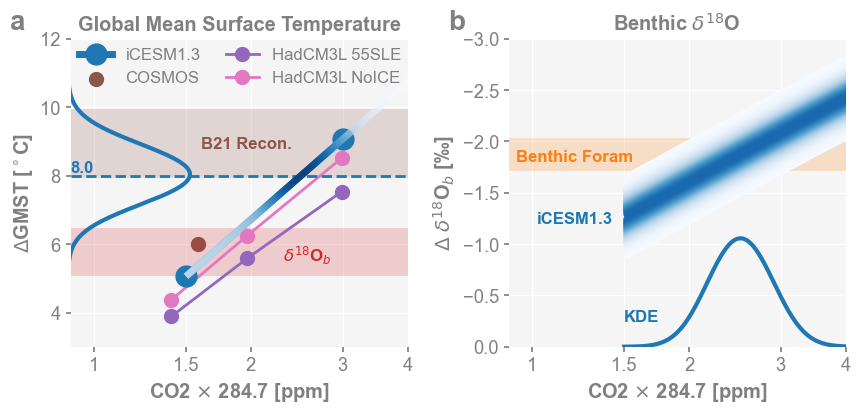

Figure saved at: "../figs/Fig.01.pdf"


In [8]:
x4c.set_style('web', font_scale=1.2)
fig, ax = x4c.subplots(
    nrow=1, ncol=2,
    figsize=(10, 4),
    ax_loc={'GMST': (0, 0), 'd18O': (0, 1)},
    wspace=0.3,
    annotation=True, annotation_kws={'style': '', 'loc_x': -0.18}
)

# Models ----------------------------------------
# GMST
ax['GMST'].set_xlabel('CO2')
ylim=[3, 12]
xlim = [0.9, 4]
xticks=[1, 1.5, 2, 3, 4]
xlabel=r'CO2 $\times$ 284.7 [ppm]'
ylabel=r'$\Delta$GMST [$^\circ$C]'

ax['GMST'].set_xscale('log')
ax['GMST'].set_xlabel(xlabel, weight='bold')
ax['GMST'].set_ylabel(ylabel, weight='bold')
ax['GMST'].set_title('Global Mean Surface Temperature', weight='bold')
ax['GMST'].set_ylim(ylim)
ax['GMST'].set_xlim(xlim)
ax['GMST'].set_xticks(xticks)
ax['GMST'].set_xticklabels(xticks)

for k, v in gmst_dict.items():
    if k == 'iCESM1.3':
        ax['GMST'].plot(v['CO2'], v['dGMST'], ms=15, lw=5, marker='o', label=lb_dict[k], color=clr_dict[k], zorder=99)
        
        colored_line(
            df_CO2pdf['CO2'],
            df_CO2pdf['dGMST'],
            df_CO2pdf['density'],
            ax['GMST'],
            cmap='Blues',
            linewidth=5,
            zorder=100,
        )
    else:
        if k == 'COSMOS Mid Miocene':
            ax['GMST'].scatter(v['CO2'], v['dGMST'], s=100, marker='o', label=lb_dict[k], color=clr_dict[k])
        else:
            ax['GMST'].plot(v['CO2'], v['dGMST'], ms=10, marker='o', label=lb_dict[k], color=clr_dict[k])

# gradient colored line
x = np.linspace(0, 15, 151)
kde_iCESM = gaussian_kde(df_CO2pdf['dGMST'].values, weights=df_CO2pdf['density'])
pdf_iCESM = kde_iCESM(x)
mle = x[np.argmax(pdf_iCESM)]
ax['GMST'].axhline(y=mle, ls='--', color='tab:blue')
ax['GMST'].text(y=mle+0.1, x=0.9, s=f'{mle:.1f}', horizontalalignment='left', color='tab:blue', fontweight='bold', fontsize=12)

ax['GMST'].fill_between(
    np.arange(0, 7, 1),
    df_proxy_GMST.loc['B21', 'lower']-df_proxy_GMST.loc['B21', 'PI'],
    df_proxy_GMST.loc['B21', 'upper']-df_proxy_GMST.loc['B21', 'PI'],
    facecolor='tab:brown', alpha=0.2,
)

ax['GMST'].fill_between(
    np.arange(0, 7, 1),
    df_proxy_GMST.loc['E24_pH', 'lower']-df_proxy_GMST.loc['E24_pH', 'PI'],
    df_proxy_GMST.loc['E24_pH', 'upper']-df_proxy_GMST.loc['E24_pH', 'PI'],
    facecolor='tab:red', alpha=0.2,
)

# KDE curve
ax['GMST-pdf'] = ax['GMST'].twiny()
ax['GMST-pdf'].plot(
    pdf_iCESM, x,
    lw=3, ls='-',
    color='tab:blue',
)

ax['GMST-pdf'].set_xlim([0.01, 1.3])
ax['GMST-pdf'].grid(False)
ax['GMST-pdf'].spines['top'].set_visible(False)  # Hide the right spine
ax['GMST-pdf'].xaxis.set_visible(False)            # Hide the right y-axis ticks and labels

# d18O --------------------------------------
upper_bd = df_proxy_d18Ob.loc['Dd18Ob', 'upper']
lower_bd = df_proxy_d18Ob.loc['Dd18Ob', 'lower']

df_density = pd.read_csv('../data/iCESM_density.csv', header=None)
density_array = np.array(df_density)

ax['d18O'].fill_between(
    np.arange(0, 9, 1), lower_bd, upper_bd,
    facecolor='tab:orange', alpha=0.2,
)

x = np.linspace(-3, 0, 1000)
ax['d18O'].contour(
    df_CO2pdf['CO2'], x, density_array.T,
    cmap='Blues',
    levels=np.linspace(0, 4, 201),
)

# iCESM
xlim = [0.9, 4]
ylim = [0, -3]
xticks=[1, 1.5, 2, 3, 4]
xlabel=r'CO2 $\times$ 284.7 [ppm]'
ylabel=r'$\Delta$ $\delta^{18}$O$_b$ [‰]'

ax['d18O'].text(0.93, -1.8, 'Benthic Foram', color='tab:orange', fontweight='bold', fontsize=12)
ax['d18O'].text(1.02, -1.2, 'iCESM1.3', color='tab:blue', fontweight='bold', fontsize=12)
ax['d18O'].text(1.5, -0.25, 'KDE', color='tab:blue', fontweight='bold', fontsize=12)

ax['d18O'].set_xscale('log')
ax['d18O'].set_xlabel(xlabel, weight='bold')
ax['d18O'].set_ylabel(ylabel, weight='bold')
ax['d18O'].set_ylim(ylim)
ax['d18O'].set_xlim(xlim)
ax['d18O'].set_xticks(xticks)
ax['d18O'].set_xticklabels(xticks)
ax['d18O'].set_title('Benthic $\\delta^{18}$O', weight='bold')

# CO2 --------------------------------------
x = df_CO2pdf['CO2']
pdf = df_CO2pdf['density']

ax['CO2'] = ax['d18O'].twinx()
x4c.set_style('web', font_scale=1.2)
ax['CO2'].plot(
    x,  pdf,
    lw=3, ls='-',
    color='tab:blue',
)

ax['CO2'].set_ylim([0, 8])
ax['CO2'].grid(False)
ax['CO2'].spines['right'].set_visible(False)  # Hide the right spine
ax['CO2'].yaxis.set_visible(False)            # Hide the right y-axis ticks and labels

# legends ---------------------------------------
ax['GMST'].legend(ncol=2, loc='upper left', fontsize=12, bbox_to_anchor=(-0.02, 1.02), columnspacing=1.5)

ax['GMST'].text(
    1.6, 8.8, 'B21 Recon.',
    color='tab:brown', fontweight='bold', fontsize=12,
)

ax['GMST'].text(
    2.3, 5.5, r'$\delta^{18}$O$_b$',
    color='tab:red', fontweight='bold', fontsize=12,
)

x4c.showfig(fig)
x4c.savefig(fig, '../figs/Fig.01.pdf')